In [42]:
from itertools import combinations
from collections import Counter
import random
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
from IPython.display import Image
from IPython.core.display import HTML 

## Rugby World Cup 2019 - Office Shares Game

In this project, we will try and predict the best shares to buy in an office competition, based on the rugby 2019 world cup.

### Basics:

Entrants ‘buy shares’ in teams. Every time a team wins a match, it gets a certain number of points. The points are distributed amongst the shareholders, proportionate to the number of shares they have bought.

Each entrant may buy 16 shares. You can take at most only 4 shares in any one team. There are no other restrictions. The number of shares per team is not fixed; the better teams will earn more points, but those points are likely to be spread among more shares. Shares cannot be ‘traded’ once the deadline has passed.

For those not so familiar with the world cup (or even with rugby in general, like me!), the world cup begins with a pool stage where the 20 teams are divided into 4 pools of 5 teams each. These pools are as follows:

In [2]:
Image(url= "https://ik.imagekit.io/rti/wp-content/uploads/2018/01/Rugby-World-Cup-Pools-Table.png", width=400)

Within a pool, each team plays every other team exactly once (so 10 games in total), the teams finishing in the top two places of each pool advance to the quarter-finals. There are various tie-breaking criteria (see https://en.wikipedia.org/wiki/2019_Rugby_World_Cup#Pool_stage), but for simplicity, we will ignore these and instead decide a tie break situation with uniform randomness.

After the pool stage, it is then a simple knock out: quarter-finals, semi-finals and then finals (with an extra game to decide third place). 

The specific points on offer in the office shares competition are as follows:

· Pool stage draw: 15 points

· Pool stage win: 30 points

· Pool runner-up: 15 points

· Pool winner: 30 points

· Q-final win: 40 points

· 3rd place play-off win: 40 points

· S-final win: 80 points

· World Cup winner: 120 points

Hence the total number of points on offer is given by: (4 pools * [{10 games * (30)} + 30+15] + 4 qfs * 40 + 1 bronze * 40 + 2 sfs * 80 + 1 final * 120)

In [3]:
print('Total points:', 4 * (10*(30) + 45) + 4*40 + 40 + 2*80 + 120)

Total points: 1860


The number of points an individual gets is then: (Points awarded to a team) x (Number of shares you own in the team) / (Total number of shares in the team)

### Odds of Winning

The first step we take is to collect a set of odds that each team has of winning in their pool and in the tournament overall. The odds associated to each team, written as [a,b,c] = ['Odds of winning pool','Overall exchange odds','Overall sports book odds'] are:

In [4]:
PoolA = {'Ireland':[1.35,12.5,10], 'Scotland':[4.6,95,51], 'Japan':[21,290,201], 'Russia':[500,1000,2001], 'Samoa':[200,1000,1001]}
PoolB = {'New Zealand':[1.39,2.56,2.37], 'South Africa':[3.55,5.4,5], 'Italy':[180,1000,751], 'Namibia':[500,1000,5001], 'Canada':[500,1000,2001]}
PoolC = {'England':[1.35,6,5], 'France':[5.9,36,26], 'Argentina':[7.8,70,51], 'Tonga':[500,1000,1001], 'USA':[500,1000,2001]}
PoolD = {'Wales':[1.76,14,12], 'Australia':[2.3,18.5,17], 'Fiji':[40,520,501], 'Georgia':[500,1000,751], 'Uruguay':[600,1000,5001]}

In [5]:
Image(url= "https://www.ruck.co.uk/wp-content/uploads/2018/03/france.png", width=700)

We also convert these odds into normalised probabilities using the following function:

In [6]:
## Normalises a pool dictionary
def Pnorm(pool):
    total = sum([1 / s[0] for s in pool.values()])
    for team in pool.keys():
        pool[team][0] = ((1 / pool[team][0])) / total
    return pool

We normalise and also combine all pools together into a tournament dictionary.

In [7]:
PoolA, PoolB, PoolC, PoolD = Pnorm(PoolA), Pnorm(PoolB), Pnorm(PoolC), Pnorm(PoolD)
P = [PoolA, PoolB, PoolC, PoolD]
P_dic = {**PoolA, **PoolB, **PoolC, **PoolD}
All = Pnorm(dict(zip(P_dic.keys(), [[(k[1]+k[2])/2] for k in P_dic.values()])))

It will also be useful to have a 'Normalisation pool'. This is an artificial pool created with one team from each of the other pools:

In [8]:
NormPool = Pnorm(dict(zip([list(pool.keys())[0] for pool in P],[[(list(pool.values())[0][1]+list(pool.values())[0][2])/2] for pool in P])))

In [9]:
print(NormPool)

{'Ireland': [0.11799780822238802], 'New Zealand': [0.5385295507106959], 'England': [0.2413591531821573], 'Wales': [0.10211348788475887]}


We can now take a look at the chances each team has of winning overall (coloured by pool):

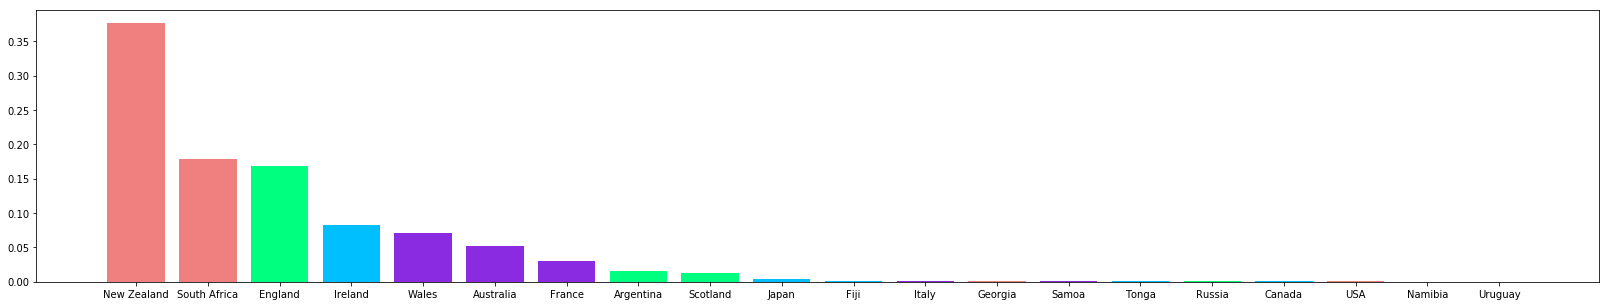

In [10]:
total_prob = sorted(All, key=lambda k: All[k][0], reverse=True)
plt.figure(figsize=(28,5))
c0, c1, c2, c3 = 'deepskyblue', 'lightcoral', 'springgreen', 'blueviolet'
plt.bar(total_prob, [All[k][0] for k in total_prob], color = [c1,c1,c2,c0,c3,c3,c3,c2,c2,c0,c0,c3,c1,c3,c0,c2,c0,c1,c2,c1,c3])
plt.show()

From this very basic analysis, we may expect most of the shares to be bought in teams such as England, Ireland, Wales, Australia etc. 

i.e. Most people may go for teams with good odds that they don't think everyone else will go for.

Then again, will people assume others are doing this and hence buy shares in New Zealand..?

### ELOs

Our approach to predict good shares to go for will involve running multiple tournament simulations and, based on a large set of shares we predict others will go for, we can then identify a good set of 16 shares an individual could pick.

In order to run tournament simulations, we require probabilities of a winner when any 2 teams play each other. To get these, we will try to estimate ELO ratings for each team based on the odds we have of them winning pools/the tournament. 

If you are not familiar with ELO ratings: https://en.wikipedia.org/wiki/Elo_rating_system

In [11]:
## Probability that TeamA wins:
def Exp(RankA, RankB):
    return 1 / (1 + 10**((RankB - RankA)/400))

The following code starts a set of teams as all having an ELO of 2000. It then plays a set number of games between the teams (on the first run through we expect them to all win approximately the same number of games). Then, based on the odds we have of teams winning, it alters the ELO ratings. Then repeat this whole process multiple times.

In [12]:
def calc_elo(pool, N = 2000, it = 10**5, show = False):
    n = len(pool)
    elos = dict(zip(pool.keys(), [2000 for _ in range(n)]))
    
    for k in range(N):
        if show == True and k%5 == 0:
            print('After', k, 'steps:')
            print(elos)
            print('\n')
            
        wins = dict(zip(pool.keys(), [0 for _ in range(n)]))
        for i in range(it):
            score = dict(zip(pool.keys(),[0 for _ in pool]))
            for game in combinations(score.keys(), 2):
                win = game[0] if random.random() < Exp(elos[game[0]], elos[game[1]]) else game[1]
                score[win] += 1
            order = [score[k] for k in sorted(score, key=lambda k: score[k], reverse=True)]
            max_score = order[0]# Best score
            wins[random.choice([team for team in score.keys() if score[team] == max_score])] += 1   # Who won

        odds = [it * s[0] for s in pool.values()]

        for i, team in enumerate(pool):
            elos[team] += (100 / it) * (odds[i] - list(wins.values())[i])

    return elos

In [13]:
calc_elo(PoolA, N=10, show=True)

After 0 steps:
{'Ireland': 2000, 'Scotland': 2000, 'Japan': 2000, 'Russia': 2000, 'Samoa': 2000}


After 5 steps:
{'Ireland': 2172.580203909478, 'Scotland': 2012.756114190825, 'Japan': 1949.867748822752, 'Russia': 1931.7534094505556, 'Samoa': 1933.0425236263889}




{'Ireland': 2226.5894078189563,
 'Scotland': 2034.36622838165,
 'Japan': 1933.6514976455044,
 'Russia': 1901.4178189011116,
 'Samoa': 1903.9750472527778}

So we run this to calculate ELOs for each pool (<font color='red'>__WARNING__</font>: this will take a while to run with the set number of iterations, hence we comment out):

In [14]:
#PoolA_elo = calc_elo(PoolA)
#PoolB_elo = calc_elo(PoolB)
#PoolC_elo = calc_elo(PoolC)
#PoolD_elo = calc_elo(PoolD)
#Norm_elo = calc_elo(NormPool)

The following will save the calculated elos:

In [15]:
#with open('PoolA_elo.pickle', 'wb') as handle:
#    pickle.dump(PoolA_elo, handle, protocol=pickle.HIGHEST_PROTOCOL)
#with open('PoolB_elo.pickle', 'wb') as handle:
#    pickle.dump(PoolB_elo, handle, protocol=pickle.HIGHEST_PROTOCOL)
#with open('PoolC_elo.pickle', 'wb') as handle:
#    pickle.dump(PoolC_elo, handle, protocol=pickle.HIGHEST_PROTOCOL)
#with open('PoolD_elo.pickle', 'wb') as handle:
#    pickle.dump(PoolD_elo, handle, protocol=pickle.HIGHEST_PROTOCOL)
#with open('Norm_elo.pickle', 'wb') as handle:
#    pickle.dump(Norm_elo, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [16]:
PoolA_elo = pickle.load(open('PoolA_elo.pickle', 'rb'))
PoolB_elo = pickle.load(open('PoolB_elo.pickle', 'rb'))
PoolC_elo = pickle.load(open('PoolC_elo.pickle', 'rb'))
PoolD_elo = pickle.load(open('PoolD_elo.pickle', 'rb'))
Norm_elo = pickle.load(open('Norm_elo.pickle', 'rb'))

Giving us the following ELOs:

In [17]:
for pool in [PoolA_elo, PoolB_elo, PoolC_elo, PoolD_elo, Norm_elo]:
    print([k for k in pool.keys()])
    print([round(v) for v in pool.values()], '\n')

['Ireland', 'Scotland', 'Japan', 'Russia', 'Samoa']
[2364, 2164, 1972, 1719, 1781] 

['New Zealand', 'South Africa', 'Italy', 'Namibia', 'Canada']
[2446, 2286, 1806, 1731, 1730] 

['England', 'France', 'Argentina', 'Tonga', 'USA']
[2354, 2123, 2086, 1719, 1719] 

['Wales', 'Australia', 'Fiji', 'Georgia', 'Uruguay']
[2346, 2301, 1921, 1722, 1710] 

['Ireland', 'New Zealand', 'England', 'Wales']
[1929, 2139, 2019, 1913] 



We may now normalise all ELOs based on the normilisation pool we made:

In [18]:
def Tnorm(pool, e = 200):
    tmp = pool.copy()
    for k in pool:
        team = list(pool.keys())[0]
        tmp[k] += Norm_elo[team] - pool[team] + e
    return tmp

elo = {**Tnorm(PoolA_elo),**Tnorm(PoolB_elo),**Tnorm(PoolC_elo),**Tnorm(PoolD_elo)}
elo = dict(zip(elo.keys(), [round(e) for e in elo.values()]))

So we now have a full set of ELOs for every team:

In [19]:
print(elo)

{'Ireland': 2129, 'Scotland': 1929, 'Japan': 1738, 'Russia': 1485, 'Samoa': 1546, 'New Zealand': 2339, 'South Africa': 2179, 'Italy': 1698, 'Namibia': 1623, 'Canada': 1623, 'England': 2219, 'France': 1987, 'Argentina': 1950, 'Tonga': 1583, 'USA': 1583, 'Wales': 2113, 'Australia': 2068, 'Fiji': 1688, 'Georgia': 1489, 'Uruguay': 1477}


### Tournament Simulation

We are now ready to define the tournament. The following code simulates one run through of the world cup and outputs a dictionary of scores for each team (based on the Office Shares Game point system):

In [20]:
def tournament():
    ## Set up a dict containing number of wins
    PoolA = {'Ireland':0, 'Scotland':0, 'Japan':0, 'Russia':0, 'Samoa':0}
    PoolB = {'New Zealand':0, 'South Africa':0, 'Italy':0, 'Namibia':0, 'Canada':0}
    PoolC = {'England':0, 'France':0, 'Argentina':0, 'Tonga':0, 'USA':0}
    PoolD = {'Wales':0, 'Australia':0, 'Fiji':0, 'Georgia':0, 'Uruguay':0}
    
    ## Describe the order of play for the quarter/semi-finals
    quarter_play = [(4,7), (1,2), (6,5), (0,3)]
    semi_play = [(0,1),(2,3)]
    
    ## Set up the quarter/semi/final lists:
    quarter = []
    semi = []
    final = []
    bronze = []
    
    ## We play the pool games first:
    for pool in [PoolA, PoolB, PoolC, PoolD]:
        for game in combinations(pool.keys(), 2):
            win = game[0] if random.random() < Exp(elo[game[0]], elo[game[1]]) else game[1]
            pool[win] += 30
        order = [pool[k] for k in sorted(pool, key=lambda k: pool[k], reverse=True)]
        max_score = order[0]# Best score
        winner = random.choice([team for team in pool.keys() if pool[team] == max_score])   # Who won
        quarter.append(winner) # Add to quarter finals
        second_score = order[1]   
        second = random.choice([team for team in pool.keys() if pool[team] == second_score and team != winner])   # Who won              # Who came second
        quarter.append(second) # Add to quarter finals
        pool[winner] += 30  # Winner gets 30pts
        pool[second] += 15  # Runner up gets 15pts
        
    ## Combine the pools into a full set:
    Wins = {**PoolA, **PoolB, **PoolC, **PoolD}
    
    ## Next play the quarter finals:
    for qp in quarter_play:
        teamA = quarter[qp[0]]
        teamB = quarter[qp[1]]
        winner = teamA if random.random() < Exp(elo[teamA], elo[teamB]) else teamB
        Wins[winner] += 40
        semi.append(winner)
    
    ## Next play the semi finals:
    for sp in semi_play:
        teamA = semi[sp[0]]
        teamB = semi[sp[1]]
        winner, loser = (teamA, teamB) if random.random() < Exp(elo[teamA], elo[teamB]) else (teamB, teamA)
        Wins[winner] += 80
        final.append(winner)
        bronze.append(loser)
        
    ## Play for bronze:
    winner = bronze[0] if random.random() < Exp(elo[bronze[0]], elo[bronze[1]]) else bronze[1]
    Wins[winner] += 40
    
    ## Play the final:
    winner = final[0] if random.random() < Exp(elo[final[0]], elo[final[1]]) else final[1]
    Wins[winner] += 120
    
    return({team:Wins[team] for team in Wins.keys()})

A quick example:

In [21]:
tournament()

{'Ireland': 150,
 'Scotland': 105,
 'Japan': 60,
 'Russia': 0,
 'Samoa': 30,
 'New Zealand': 390,
 'South Africa': 225,
 'Italy': 60,
 'Namibia': 30,
 'Canada': 0,
 'England': 190,
 'France': 185,
 'Argentina': 60,
 'Tonga': 0,
 'USA': 30,
 'Wales': 150,
 'Australia': 105,
 'Fiji': 60,
 'Georgia': 30,
 'Uruguay': 0}

We may now score a tournament based on a chosen set of shares by the individual and the group:

In [22]:
def score(shares, total_shares, T):
    total = 0
    for team in shares.keys():
        total += T[team] * (shares[team] / total_shares[team])
    return total

And so, given we run a tournament and own the shares given by 'shares', if everyone else owns the shares given by 'total_shares', then we can work out our score. For example:

In [23]:
T = tournament()
shares = {'England':4, 'New Zealand':2, 'South Africa':2, 'Fiji':4, 'France':4}
total_shares = {'Ireland': 10, 'Scotland': 3, 'Japan': 20, 'Russia': 5, 'Samoa': 8, 'New Zealand': 30, 'South Africa': 50, 'Italy': 12, 'Namibia': 0, 'Canada': 3, 'England': 35, 'France': 30, 'Argentina': 30, 'Tonga': 4, 'USA': 5, 'Wales': 30, 'Australia': 3, 'Fiji': 3, 'Georgia': 3, 'Uruguay': 6}
score(shares, total_shares, T)

138.3904761904762

More interestingly we can now view multiple scores for the same set of shares:

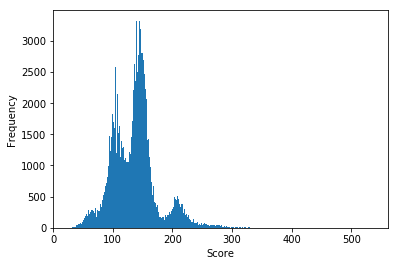

In [24]:
d = []
for i in range(10**5):
    T = tournament()
    shares = {'England':4, 'New Zealand':2, 'South Africa':2, 'Fiji':4, 'France':4}
    total_shares = {'Ireland': 10, 'Scotland': 3, 'Japan': 20, 'Russia': 5, 'Samoa': 8, 'New Zealand': 30, 'South Africa': 50, 'Italy': 12, 'Namibia': 0, 'Canada': 3, 'England': 35, 'France': 30, 'Argentina': 30, 'Tonga': 4, 'USA': 5, 'Wales': 30, 'Australia': 3, 'Fiji': 3, 'Georgia': 3, 'Uruguay': 6}
    d.append(score(shares, total_shares, T))
    
plt.hist(d, bins = 300)
plt.xlabel('Score')
plt.ylabel('Frequency')
plt.show()

In the above example, we see 2 main peaks at about 100 and 150. Perhaps these correspond to England or New Zealand winning.

### Tactics

In order to pick shares wisely, we need to have some sort of model of how other members of the office will pick shares. Thus, we define a few simple tactics they might employ to pick teams:

In [25]:
## Go for full 4 shares of 4 "good" teams
def good_tactic():
    good_teams = ['New Zealand', 'England', 'Wales', 'South Africa', 'Ireland', 'Australia']
    return Counter({r:4 for r in random.sample(good_teams, 4)})

## Spread out shares on "good" teams
def spread_tactic():
    good_teams = ['New Zealand', 'England', 'Wales', 'South Africa', 'Ireland', 'Australia']
    shares = {team:4 for team in good_teams} # Start with all shares on 4
    while sum([i for i in shares.values()]) != 16:
        team = random.choice([i for i in shares.keys()])     # Choose a random team
        shares[team] -= 1               # Decrease the share by 1
        if shares[team] == 0:           # If it hits 0, delete it
            del shares[team]
    return Counter(shares)
    
## Return shares of random teams
def random_tactic():
    shares = {team:4 for team in All.keys()} # Start with all shares on 4
    while sum([i for i in shares.values()]) != 16:
        team = random.choice([i for i in shares.keys()])     # Choose a random team
        shares[team] -= 1               # Decrease the share by 1
        if shares[team] == 0:           # If it hits 0, delete it
            del shares[team]
    return Counter(shares)
    
## Return shares of "middle teams"
def middle_tactic():
    middle_teams = ['Australia', 'France', 'Scotland', 'Argentina', 'Japan', 'Fiji']
    shares = {team:4 for team in middle_teams} # Start with all shares on 4
    while sum([i for i in shares.values()]) != 16:
        team = random.choice([i for i in shares.keys()])     # Choose a random team
        shares[team] -= 1               # Decrease the share by 1
        if shares[team] == 0:           # If it hits 0, delete it
            del shares[team]
    return Counter(shares)
    
## Go for full 4 shares of 4 teams across pools
def pool_tactic():
    shares = {}
    for pool in [PoolA, PoolB, PoolC, PoolD]:
        team = random.choice([i for i in pool.keys()])
        shares[team] = 4
    return Counter(shares)

## Ben tactic: 4 on NZ and SA.
def ben_tactic():
    good_teams = All.keys()
    shares = {team:4 for team in good_teams} # Start with all shares on 4
    while sum([i for i in shares.values()]) != 16:
        team = random.choice([i for i in shares.keys()])     # Choose a random team
        if team == 'New Zealand' or team == 'South Africa':
            continue
        shares[team] -= 1               # Decrease the share by 1
        if shares[team] == 0:           # If it hits 0, delete it
            del shares[team]
    return Counter(shares)

In [26]:
middle_tactic()

Counter({'Australia': 3,
         'France': 2,
         'Scotland': 3,
         'Argentina': 2,
         'Japan': 3,
         'Fiji': 3})

Now we can form a set of full office shares. For example, if one person plays each of the 6 tactics:

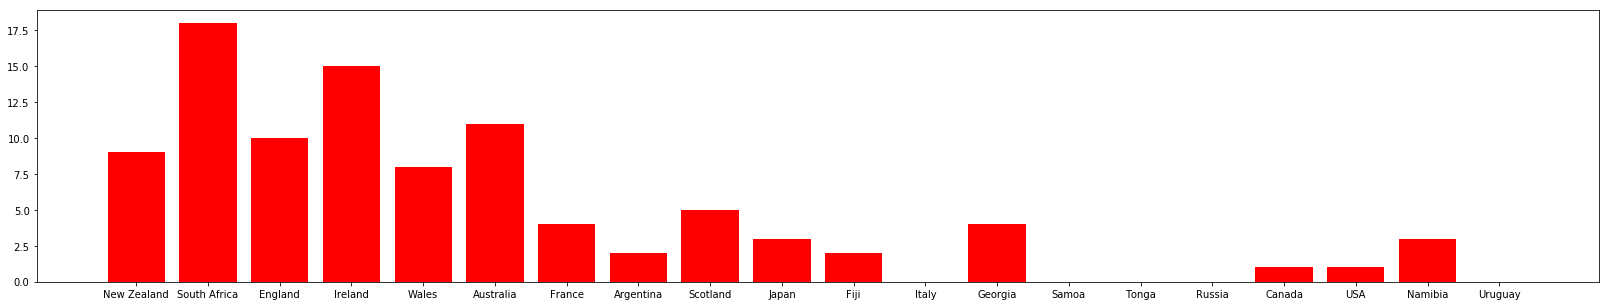

In [27]:
shares = good_tactic() + spread_tactic() + middle_tactic() + random_tactic() + pool_tactic() + ben_tactic()
plt.figure(figsize=(28,5))
plt.bar(total_prob,[shares[k] for k in total_prob], color = 'r')
plt.show()

This is something like what we may expect the distribution of shares to look like. However, this still remains one of the hardest things to model...

### Office Shares Game

We are now ready to run multiple games to try and predict a good set of shares to go for, given a set of tactics.

Let $n$ be the number of different samples of share distributions we take and $m$ be the number of tournaments we play for each sample.

In [28]:
def run_game(tactics, shares, n, m, details = False, stats = False):
    S = []
    for i in range(n):
        total_shares = Counter(shares)
        for _ in range(tactics[0]):
            total_shares += good_tactic()
        for _ in range(tactics[1]):
            total_shares += spread_tactic()
        for _ in range(tactics[2]):
            total_shares += random_tactic()
        for _ in range(tactics[3]):
            total_shares += middle_tactic()
        for _ in range(tactics[4]):
            total_shares += pool_tactic()
        for _ in range(tactics[5]):
            total_shares += ben_tactic()
            
        for j in range(m):
            T = tournament()
            S.append(score(shares, total_shares, T))
            
        if details:
            print('Total shares bought:')
            plt.figure(figsize=(28,5))
            plt.bar(total_prob,[total_shares[k] for k in total_prob], color = 'r')
            plt.show()
            
    if details:
        print('Scores:',S)
        
    if stats:
        plt.hist(S, bins = 300, label = str(tactics))
        plt.xlabel('Score')
        plt.ylabel('Frequency')
        #plt.title(tactics)
        #plt.show()
    
    return sum(S) / len(S)

For example:

Tactic: Counter({'Japan': 3, 'Argentina': 3, 'USA': 3, 'England': 2, 'Samoa': 1, 'Namibia': 1, 'Tonga': 1, 'Australia': 1, 'Georgia': 1})
Total shares bought:


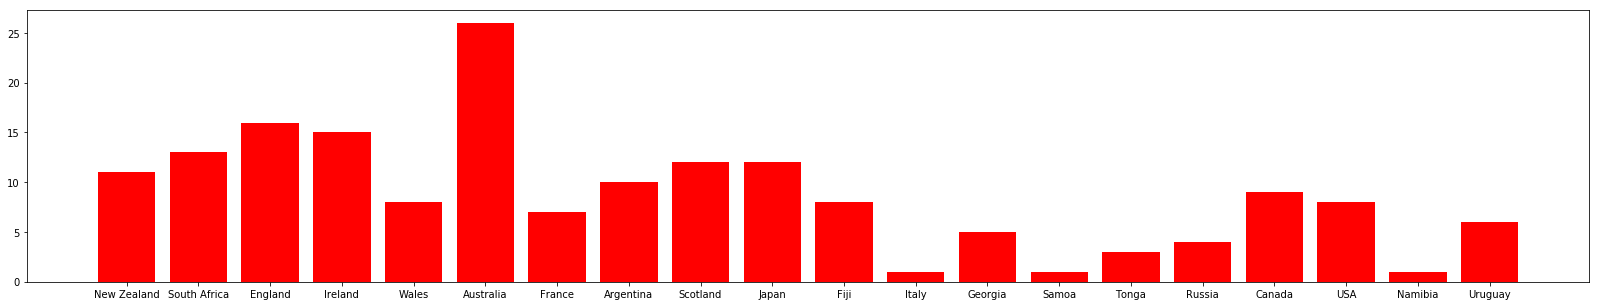

Scores: [171.8846153846154]


171.8846153846154

In [30]:
tactic = random_tactic()
print('Tactic:', tactic)
run_game([2,2,2,2,2,0], tactic, 1, 1, details = True)

And so we can now run multiple games and see our score distribution:

Tactic: Counter({'Australia': 4, 'France': 3, 'South Africa': 2, 'Argentina': 2, 'New Zealand': 1, 'England': 1, 'Wales': 1, 'Georgia': 1, 'Uruguay': 1})


258.63483350221463

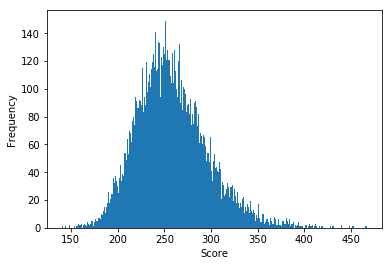

In [31]:
tactic = random_tactic()
print('Tactic:', tactic)
run_game([1,1,1,1,1,1], tactic, 100, 100, stats = True)

So, given we have predicted the office tactics well, we could expect to get approximately the average score outputed by run_game.

### Scenarios

We are now ready to generate some "good" shares, based on predicted tactics by others. We will guess that the following scenarios may happen:

In [32]:
## 10 entrants:
Scenario1 = [1,5,1,1,1,1] # Most people go for "good" teams and spread
Scenario2 = [1,1,1,6,1,0] # Most people go for "middle" teams
Scenario3 = [1,1,6,1,1,0] # Most people go for random teams
Scenario4 = [2,2,2,2,2,0] # A range of strategies

# ------------------- #

## 20 entrants:
Scenario5 = [2*s for s in Scenario1] # Most people go for "good" teams and spread
Scenario6 = [2*s for s in Scenario2] # Most people go for "middle" teams
Scenario7 = [2*s for s in Scenario3] # Most people go for random teams
Scenario8 = [2*s for s in Scenario4] # A range of strategiesm

For each scenario, we will play $k$ random strategy against $n$ versions of that scenario, $m$ times, and see what the average score is. We will keep the top 3 strategies from each scenario.

In [33]:
def play_scenarios(n,m,k, progress = False):
    Top_strats = []
    for scenario in [Scenario1,Scenario2,Scenario3,Scenario4,Scenario5,Scenario6,Scenario7,Scenario8]:
        top3 = [[None,0],[None,0],[None,0]]
        for i in range(k):
            shares = ben_tactic()
            r_shares = random_tactic()
            s = run_game(scenario, shares, n, m)
            r = run_game(scenario, r_shares, n, m)
            for j in range(3):
                if s > top3[j][1]:
                    top3[j][0] = shares
                    top3[j][1] = s
                    break
            for j in range(3):
                if r > top3[j][1]:
                    top3[j][0] = r_shares
                    top3[j][1] = r
                    break
        Top_strats.append(top3)
        if progress:
            print(top3[0])
            print('\n')
    return Top_strats

In [34]:
#Top = play_scenarios(100,100,200, progress = True)

In [35]:
#with open('Top.pickle', 'wb') as handle:
#    pickle.dump(Top, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [36]:
Top = pickle.load(open('Top.pickle', 'rb'))

In [37]:
def plot_tactic(tactics):
    n = len(tactics)
    for i, tactic in enumerate(tactics):
        fig = plt.figure(figsize=(20, 12))
        plt.subplot(221)
        run_game(Scenario1, tactic, 100, 100, stats = True)
        run_game(Scenario2, tactic, 100, 100, stats = True)
        run_game(Scenario3, tactic, 100, 100, stats = True)
        run_game(Scenario4, tactic, 100, 100, stats = True)
        plt.legend()
        
        plt.subplot(222)
        run_game(Scenario5, tactic, 100, 100, stats = True)
        run_game(Scenario6, tactic, 100, 100, stats = True)
        run_game(Scenario7, tactic, 100, 100, stats = True)
        run_game(Scenario8, tactic, 100, 100, stats = True)
        plt.legend()

        fig.suptitle(tactic)
        fig.subplots_adjust(top=0.95)
        plt.show()

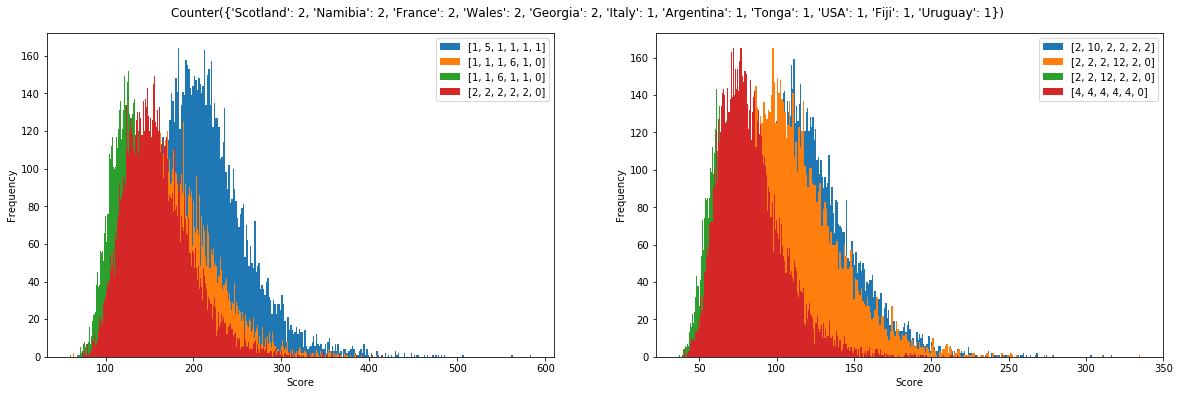

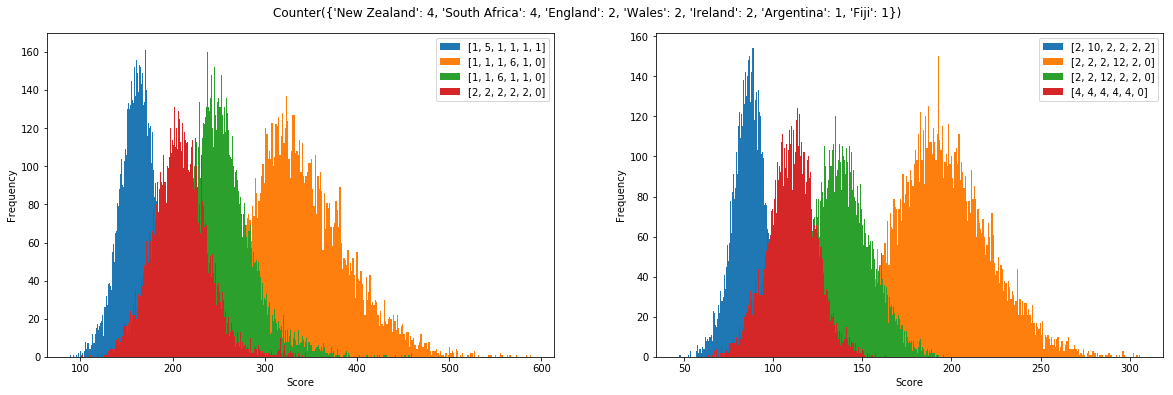

In [38]:
plot_tactic([s[0][0] for s in Top][0:2])

Notice that on the 'ben_tactic' option, the blue and orange peeks are seperated most. This is due to this tactic doing well against people picking "middle" teams but not so good when everyone else picks "good" teams.

However, when the random tactics do well, the blue and orange peaks are much closer together. 

### Expected Share Scores & Final Prediction

Using similar code to before, but this time keeping track of how much a single share for each team was worth each tournament throughout the simulations - we can try and approximate the expected share scores for a given set of office tactics.

In [39]:
def find_shares(tactics, n, m):
    S = []
    scores = Counter(dict(zip(All.keys(), [0 for _ in range(len(All))])))
    for i in range(n):
        total_shares = Counter()
        for _ in range(tactics[0]):
            total_shares += good_tactic()
        for _ in range(tactics[1]):
            total_shares += spread_tactic()
        for _ in range(tactics[2]):
            total_shares += random_tactic()
        for _ in range(tactics[3]):
            total_shares += middle_tactic()
        for _ in range(tactics[4]):
            total_shares += pool_tactic()
        for _ in range(tactics[5]):
            total_shares += ben_tactic()
            
        for j in range(m):
            T = tournament()
            for team in T:
                if total_shares[team] != 0:
                    scores[team] += (1/total_shares[team]) * T[team]
    
    for k in scores:
        scores[k] /= n*m
    
    return scores 

Printing these out in a nice table for each scenario:

In [40]:
def ess_table(tactics):
    ess = find_shares(tactics, 1000, 1000)
    df = pd.DataFrame.from_dict(ess, orient='index').sort_values(by=[0], ascending=False).reset_index()
    df.columns = ['Team', 'Score Per Share']
    display(df[:12].style.apply(lambda x: ['background: lightgreen' if x['Score Per Share'] > df['Score Per Share'].mean() else '' for i in x], axis=1))

In [43]:
ess_table(Scenario1)

,Team,Score Per Share
0,Scotland,29.6277
1,France,28.7053
2,Argentina,25.4904
3,Japan,17.3515
4,Fiji,15.0859
5,New Zealand,13.8124
6,Italy,13.641
7,England,12.1519
8,Canada,10.8403
9,Namibia,10.6089


In [44]:
ess_table(Scenario2)

,Team,Score Per Share
0,New Zealand,52.7865
1,England,40.2496
2,South Africa,34.1926
3,Wales,33.3689
4,Ireland,33.0814
5,Italy,11.5888
6,Samoa,9.18171
7,Canada,8.73798
8,Namibia,8.38949
9,Georgia,7.46612


In [45]:
ess_table(Scenario3)

,Team,Score Per Share
0,New Zealand,31.5556
1,England,22.0119
2,South Africa,20.3606
3,Ireland,19.1701
4,Wales,18.2722
5,France,15.7713
6,Scotland,15.7557
7,Argentina,12.9337
8,Australia,12.7082
9,Italy,9.66511


In [46]:
ess_table(Scenario4)

,Team,Score Per Share
0,New Zealand,23.2369
1,England,16.7458
2,South Africa,15.2465
3,Scotland,14.7032
4,France,14.478
5,Wales,14.3724
6,Ireland,14.0856
7,Italy,12.7985
8,Argentina,12.6607
9,Samoa,9.95906


After some thought, I decided that Scenario1 is hopefully not so likely (fingers crossed some people go completely against the odds). Therefore, I will try and optimise for Scenario4 (whose histogram looks like what we may expect?). Strangely enough, optimising for Scenario4, also helps optimise Scenarios 2 and 3 even more so...

We run similar code to before, but this time keeping track of all tactics entered into each tournament, in order to work out if the chosen set of shares comes out on top! We output the percentage of wins for the given shares, for each of Scenarios 1-4.

In [47]:
def check_wins(n, m, shares):
    S = []
    for scenario in [Scenario1,Scenario2,Scenario3,Scenario4,Scenario5,Scenario6,Scenario7,Scenario8]:
        s = 0
        for i in range(n):
            total_shares = Counter(shares)
            tactics = []
            for _ in range(scenario[0]):
                t = good_tactic()
                total_shares += t
                tactics.append(t)
            for _ in range(scenario[1]):
                t = spread_tactic()
                total_shares += t
                tactics.append(t)
            for _ in range(scenario[2]):
                t = random_tactic()
                total_shares += t
                tactics.append(t)
            for _ in range(scenario[3]):
                t = middle_tactic()
                total_shares += t
                tactics.append(t)
            for _ in range(scenario[4]):
                t = pool_tactic()
                total_shares += t
                tactics.append(t)
            for _ in range(scenario[5]):
                t = ben_tactic()
                total_shares += t
                tactics.append(t)
                
            for j in range(m):
                T = tournament()
                check = True
                my_score = score(shares, total_shares, T)
                for t in tactics:
                    if score(t, total_shares, T) > my_score:
                        check = False
                        break
                if check:    
                    s += 1
        S.append(round(s/(n*m) * 100))
    return S

Now, by looking at ess_table(Scenario4) above, we know the teams that should earn us the most points in Scenario4. Playing around with the amount of shares we assign each team leads to the following set of shares as a good candidate:

In [48]:
shares = {'Ireland': 1,
         'Scotland': 1,
         'New Zealand': 4,
         'South Africa': 3,
         'Italy': 1,
         'England': 3,
         'France': 1,
         'Wales': 2}
print(check_wins(1000,100,shares))

[10, 56, 44, 44, 4, 38, 27, 25]


So, given the office tactics are chosen similar to Scenario 2, 3 or 4 (with ~10 entrants), then our simulations give us a better than 40% chance of winning!